This is a final project...

Loading the data

In [1]:
import math
import operator
import pandas as pd
import pickle

data_dict = pickle.load( open("../final_project/final_project_dataset.pkl", "r") )

## Removing the Outlier
data_dict.pop("TOTAL", 0)

#financial_features
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                      'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 
                      'director_fees']
email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 
                  'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
poi_feature = ['poi']

In [2]:
columns = financial_features + email_features + poi_feature
my_data = pd.DataFrame(columns=columns)

for key, value in data_dict.iteritems():
    cols = []
    items = []
    for coluna, valor in value.iteritems():
        cols.append(coluna)
        items.append(valor)
    row = pd.DataFrame([items], columns=cols, index=[key])
    my_data = my_data.append(row)

# Count and Fill NANs
for f in financial_features + email_features:
    print f + ' NANs: ' + str(my_data.loc[my_data[f]=='NaN', f].count())
    my_data.loc[my_data[f]=='NaN', f] = 0



salary NANs: 51
deferral_payments NANs: 107
total_payments NANs: 21
loan_advances NANs: 142
bonus NANs: 64
restricted_stock_deferred NANs: 128
deferred_income NANs: 97
total_stock_value NANs: 20
expenses NANs: 51
exercised_stock_options NANs: 44
other NANs: 53
long_term_incentive NANs: 80
restricted_stock NANs: 36
director_fees NANs: 129
to_messages NANs: 59
email_address NANs: 34
from_poi_to_this_person NANs: 59
from_messages NANs: 59
from_this_person_to_poi NANs: 59
shared_receipt_with_poi NANs: 59


In [3]:
# choosing few financial features
financial_features = ['bonus', 'salary', 'total_payments', 'total_stock_value']
my_data = my_data[poi_feature + email_features + financial_features]

# updating email 
my_data.loc[my_data['email_address']==0, 'email_address'] = ''


In [93]:
# Reescaling financial_features
from sklearn.preprocessing import MinMaxScaler
financial_features_sc = ['bonus_sc', 'salary_sc', 'total_payments_sc', 'total_stock_value_sc']
data_f = my_data[financial_features]
scaler = MinMaxScaler(feature_range=(0, 100))
scaler.fit(data_f)

#scaler.fit(data2)
data_f = pd.DataFrame(scaler.transform(data_f), columns=[financial_features_sc], index=my_data.index.values)
#df2 = pd.DataFrame(scaler.transform(data2), columns=['C', 'D'], index=my_data.index.values)
#df[['C', 'D']] = df2
#print data_f


<type 'numpy.ndarray'>


In [5]:
import numpy as np
#email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 
#                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
    
# Selecting and scaling email_features
#data_e = my_data[email_features]
data_e = pd.DataFrame()
data_percent = pd.DataFrame(index=my_data.index.values)
data_e.loc[:, ('from_to_poi')] = my_data.loc[:,('from_this_person_to_poi')] + my_data.loc[:,('from_poi_to_this_person')]
data_e.loc[:, ('total_messages')] = my_data.loc[:, ('to_messages')] + my_data.loc[:, ('from_messages')] 
#print data_e
data_e.loc[:, ('total_messages')] = pd.to_numeric(data_e.loc[:, ('total_messages')]) 
data_e.loc[:, ('from_to_poi')] = pd.to_numeric(data_e.loc[:, ('from_to_poi')])
data_percent.loc[:, ('percent_from_to_poi')] = np.where(data_e.loc[:, ('total_messages')] > 0, 
                                                  (data_e.loc[:, ('from_to_poi')]/data_e.loc[:, ('total_messages')]) * 100, 0)
scaler = MinMaxScaler(feature_range=(0, 100))
scaler.fit(data_e)
data_e = pd.DataFrame(scaler.transform(data_e), columns=['from_to_poi_sc', 'total_messages_sc' ], index=my_data.index.values)
data_e['percent_from_to_poi'] = data_percent
data_e = data_e.drop('total_messages_sc', axis=1)

#df[['C', 'D']] = df2
data_sc = data_f
data_sc[['from_to_poi_sc', 'percent_from_to_poi']] = data_e
data_sc['poi'] = my_data['poi'].astype(int)
#del data_e
#del data_f
#del my_data
#del data_percent
print data_sc.dtypes

bonus_sc                float64
salary_sc               float64
total_payments_sc       float64
total_stock_value_sc    float64
from_to_poi_sc          float64
percent_from_to_poi     float64
poi                       int32
dtype: object


In [91]:
# Spliting Data and PCA

from sklearn.model_selection import train_test_split
from time import time
from sklearn.decomposition import PCA

#X = data_sc.loc[:, data_sc.columns != 'poi']
#['bonus_sc', 'salary_sc', 'total_payments_sc', 'total_stock_value_sc']
# 'from_to_poi_sc', 'percent_from_to_poi
#X = data_sc.loc[:, ('salary_sc', 'total_stock_value_sc')]
X = data_sc.loc[:, data_sc.columns != 'poi']
y = data_sc.loc[:, data_sc.columns == 'poi'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

pca = PCA(whiten=True, n_components=6).fit(X_train)
#print pca.singular_values_
print pca.explained_variance_ratio_
#print pca.components_
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

[ 0.65629449  0.17597482  0.09436125  0.04449257  0.0180519   0.01082498]


In [38]:
#Grid Search
from sklearn.model_selection import GridSearchCV
print "Decision Tree"

from sklearn import tree
parameters = {'min_samples_split':range(2, 10), 'min_samples_leaf':range(1, 10), 'splitter':['best', 'random']}
dt = tree.DecisionTreeClassifier(random_state=0)
clf_dt = GridSearchCV(dt, parameters)
t0 = time()
clf_dt.fit(X_train_pca, y_train['poi'].values)
print "training time:", round(time()-t0, 3), "s"
print clf_dt.best_params_

print "Regression"

from sklearn import linear_model
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
reg = linear_model.LinearRegression()
clf_r = GridSearchCV(reg, parameters)
t0 = time()
clf_r.fit(X_train_pca, y_train['poi'].values)
print "training time:", round(time()-t0, 3), "s"
print clf_r.best_params_

print "SVM"

from sklearn import svm

parameters = {'kernel':('linear', 'rbf'), 'C':range(1, 100)}
svr = svm.SVC() 
clf_s = GridSearchCV(svr, parameters)
t0 = time()
clf_s.fit(X_train_pca, y_train['poi'].values)
print "training time:", round(time()-t0, 3), "s"
print clf_s.best_params_


Decision Tree
training time: 0.644 s
{'min_samples_split': 6, 'splitter': 'random', 'min_samples_leaf': 2}
Regression
training time: 0.031 s
{'copy_X': True, 'normalize': True, 'fit_intercept': True}
SVM
training time: 2.953 s
{'kernel': 'linear', 'C': 1}


In [75]:
#Validation
print "Naive Bayes"

from sklearn.naive_bayes import GaussianNB
t0 = time()
clf_nb_v = GaussianNB()
clf_nb_v.fit(X_train_pca, y_train)
print "training time:", round(time()-t0, 3), "s"
accuracy_nb = clf_nb_v.score(X_test_pca, y_test)
print "score: " + str(accuracy_nb)

print "Decision Tree"
clf_dt_v= tree.DecisionTreeClassifier(random_state = 0, min_samples_split = 6, splitter = 'random', min_samples_leaf = 2)
t0 = time()
clf_dt_v.fit(X_train_pca, y_train)
print "training time:", round(time()-t0, 3), "s"
accuracy_dt = clf_dt_v.score(X_test_pca, y_test)
print "score: " + str(accuracy_dt)

print "Regression"
clf_reg_v = linear_model.LinearRegression(copy_X = 'True', normalize = 'False', fit_intercept = 'True')
t0 = time()
clf_reg_v.fit(X_train_pca, y_train)
print "training time:", round(time()-t0, 3), "s"
accuracy_reg = clf_reg_v.score(X_test_pca, y_test)
print "score: " + str(accuracy_reg)

print "SVM"
clf_svr_v = svm.SVC(random_state=0, kernel = 'linear', C = 1)
t0 = time()
clf_svr_v.fit(X_train_pca, y_train)
print "training time:", round(time()-t0, 3), "s"
accuracy_svr = clf_svr_v.score(X_test_pca, y_test)
print "score: " + str(accuracy_svr)


Naive Bayes
training time: 0.001 s
score: 0.818181818182
Decision Tree
training time: 0.002 s
score: 0.863636363636
Regression
training time: 0.0 s
score: 0.300179644508
SVM
training time: 0.004 s
score: 0.840909090909


In [92]:
#Evaluation Metric
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score

print recall_score(y_test, clf_dt_v.predict(X_test))
list_p = clf_dt_v.predict(X_test)
#print precision_score(y_test, clf_svr_v.predict(X_test_pca))
#print recall_score(y_test, clf_svr_v.predict(X_test_pca))
count = 0
value_1 = 0
predict_1 = 0
for i in range(0, len(y_test)):
    count += 1
    if y_test.values[i]==1:
        value_1 +=1
    if list_p[i] == 1:
        predict_1 += 1
    #print 'predict: ' + str(list_p[i]) + ' actual value: ' + str(y_test.values[i])
print count
print value_1
print predict_1

0.142857142857
44
7
4


Regression
training time: 0.002 s
score: 0.204874033065
SVM
training time: 0.002 s
score: 0.840909090909


In [50]:
def return_list_array(data_frame, feature1, feature2):
    feature_list = []
    poi_list = []
    for index, row in data_frame.iterrows():
        tmp_list = []
        tmp_list.append(float(row[feature_1]))
        tmp_list.append(float(row[feature_2]))
        poi_list.append(float(row['poi']))
        feature_list.append(np.array(tmp_list))
    return poi_list, feature_list
#print return_list_array(data_sc, 'bonus_sc', 'salary_sc')

def Draw(pred, features, poi, mark_poi=False, name="image.png", f1_name="feature 1", f2_name="feature 2"):
    """ some plotting code designed to help you visualize your clusters """

    ### plot each cluster with a different color--add more colors for
    ### drawing more than five clusters
    colors = ["b", "c", "k", "m", "g"]
    for ii, pp in enumerate(pred):
        plt.scatter(features[ii][0], features[ii][1], color = colors[pred[ii]])

    ### if you like, place red stars over points that are POIs (just for funsies)
    if mark_poi:
        for ii, pp in enumerate(pred):
            if poi[ii]:
                plt.scatter(features[ii][0], features[ii][1], color="r", marker="*")
    plt.xlabel(f1_name)
    plt.ylabel(f2_name)
    plt.savefig(name)
    plt.show()

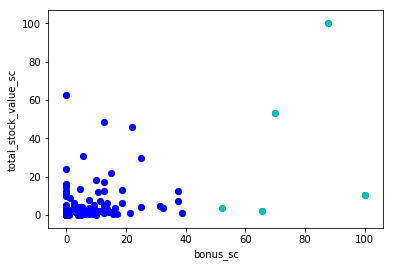

In [410]:
### in the "clustering with 3 features" part of the mini-project,
### you'll want to change this line to 
### for f1, f2, _ in finance_features:
### (as it's currently written, the line below assumes 2 features)

#feature_1 = 'from_to_poi_sc'
feature_1 = 'bonus_sc'
feature_2 = 'total_stock_value_sc'

#financial_features = ['bonus', 'salary', 'total_payments', 'total_stock_value']

import matplotlib.pyplot as plt
poi_list, data_features = return_list_array(data_sc, feature_1, feature_2)
for f1, f2 in data_features:
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.scatter( f1, f2)
#plt.show()

from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)
km.fit_predict(data_features)
pred = km.predict(data_features)

try:
    Draw(pred, data_features, poi_list, mark_poi=False, name="clusters.pdf", f1_name=feature_1, f2_name=feature_2)
except NameError:
    print "no predictions object named pred found, no clusters to plot"


In [106]:
for key in financial_features:
    count=0
    for k, v in data_dict.iteritems():
        if math.isnan(float(v[key])):
            v[key] = 0.0

# choosing a few financial features
financial_features = ['total_stock_value', 'total_payments', 'salary', 'bonus']

# finding min and max and reescaling
my_data = {}
for f_key in financial_features:    
    max_value = 0.0
    min_value = 'NaN'  
    for k, v in data_dict.iteritems(): 
        dict_item = {}
        feature_value = v[f_key]
        dict_item[f_key] = feature_value
        if math.isnan(float(min_value)):
            min_value = feature_value
        else:
            if v[f_key] < min_value:
                min_value = feature_value
        if feature_value > max_value:
            max_value = feature_value
    my_data[k] = dict_item
    print f_key + ' max value: ' + str(max_value)
    print f_key + ' min value: ' + str(min_value)

total_stock_value max value: 49110078
total_stock_value min value: -44093
{'GLISAN JR BEN F': {'total_stock_value': 778546}}
total_payments max value: 103559793
total_payments min value: 0.0
{'GLISAN JR BEN F': {'total_payments': 1272284}}
salary max value: 1111258
salary min value: 0.0
{'GLISAN JR BEN F': {'salary': 274975}}
bonus max value: 8000000
bonus min value: 0.0
{'GLISAN JR BEN F': {'bonus': 600000}}


In [ ]:
# Understanding email features

In [75]:
email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 
                  'from_this_person_to_poi', 'shared_receipt_with_poi'] 
email_features.remove('email_address')
count_keys = {}
unique_names = set()
for key in email_features:
    count=0
    for k, v in data_dict.iteritems():
        if math.isnan(float(v[key])):
            unique_names.add(k)
            count+=1
    count_keys[key] = count
print sorted(count_keys.items(), key=operator.itemgetter(1))
print len(unique_names)

[('to_messages', 59), ('from_messages', 59), ('shared_receipt_with_poi', 59), ('from_poi_to_this_person', 59), ('from_this_person_to_poi', 59)]
59


Running a k_means algorithm to find outliers